In [1]:
# IMPORT TOOLS
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


plt.style.use('seaborn-v0_8')
print("✅ All tools imported successfully")

✅ All tools imported successfully


In [2]:
# DOWNLOAD STOCK DATA

ticker = "SPY"
data = yf.download(ticker,start="2018-01-01", end="2023-12-31")

print("📊 First 5 rows of our data:")
print(data.head())

print("\n 📈Data info:")
print(data.info())

C:\Users\Aadya Nair\AppData\Local\Temp\ipykernel_9244\1188041409.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker,start="2018-01-01", end="2023-12-31")
[*********************100%***********************]  1 of 1 completed

📊 First 5 rows of our data:
Price            Close        High         Low        Open    Volume
Ticker             SPY         SPY         SPY         SPY       SPY
Date                                                                
2018-01-02  237.909180  237.944594  236.696491  237.085971  86655700
2018-01-03  239.413910  239.564402  238.077284  238.077284  90070400
2018-01-04  240.423004  240.909868  239.475885  240.060105  80636400
2018-01-05  242.025253  242.149164  240.724041  241.219738  83524000
2018-01-08  242.467804  242.627129  241.635735  241.927832  57319200

 📈Data info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1509 entries, 2018-01-02 to 2023-12-29
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   (Close, SPY)   1509 non-null   float64
 1   (High, SPY)    1509 non-null   float64
 2   (Low, SPY)     1509 non-null   float64
 3   (Open, SPY)    1509 non-null   float64
 4   (Volume, SPY)

In [3]:
# CALCULATE MOVING AVERAGES
short_window = 50
long_window = 200

data['Short_MA'] = data['Close'].rolling(window=short_window).mean()
data['Long_MA'] = data['Close'].rolling(window=long_window).mean()

print("📊Data with Moving Averages:")
print(data[['Close','Short_MA','Long_MA']].tail(10))

📊Data with Moving Averages:
Price            Close    Short_MA     Long_MA
Ticker             SPY                        
Date                                          
2023-12-15  459.360870  430.906122  418.335549
2023-12-18  461.944824  431.770649  418.696864
2023-12-19  464.753876  432.637743  419.070874
2023-12-20  458.313660  433.332166  419.442570
2023-12-21  462.659332  434.078800  419.832861
2023-12-22  463.589172  434.895891  420.263280
2023-12-26  465.546661  435.794242  420.730723
2023-12-27  466.388428  436.620917  421.205027
2023-12-28  466.564575  437.451506  421.649504
2023-12-29  465.213867  438.368351  422.099038


In [4]:
# Create PROPER trading signals - CLEAN VERSION
# 1 = Buy, 0 = Cash (sell/exit)
data['Signal'] = 0
data['Position'] = 0

# Convert to lists for clean iteration (avoids pandas warnings)
short_ma_list = data['Short_MA'].tolist()
long_ma_list = data['Long_MA'].tolist()
signal_list = [0] * len(data)

# Simple rule: Buy when Short MA crosses ABOVE Long MA, else Cash
for i in range(1, len(data)):
    if pd.isna(short_ma_list[i]) or pd.isna(long_ma_list[i]):
        continue
        
    # Current and previous values
    current_short = short_ma_list[i]
    current_long = long_ma_list[i]
    prev_short = short_ma_list[i-1] 
    prev_long = long_ma_list[i-1]
    
    # Buy signal: Short MA crosses ABOVE Long MA
    if prev_short <= prev_long and current_short > current_long:
        signal_list[i] = 1
        
    # Sell signal: Short MA crosses BELOW Long MA
    elif prev_short >= prev_long and current_short < current_long:
        signal_list[i] = 0

# Convert back to pandas series
data['Signal'] = signal_list

# Forward-fill the position (once we buy, stay invested until we sell)
data['Position'] = data['Signal']
data['Position'] = data['Position'].replace(0, method='ffill')

C:\Users\Aadya Nair\AppData\Local\Temp\ipykernel_9244\2448225079.py:35: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  data['Position'] = data['Position'].replace(0, method='ffill')


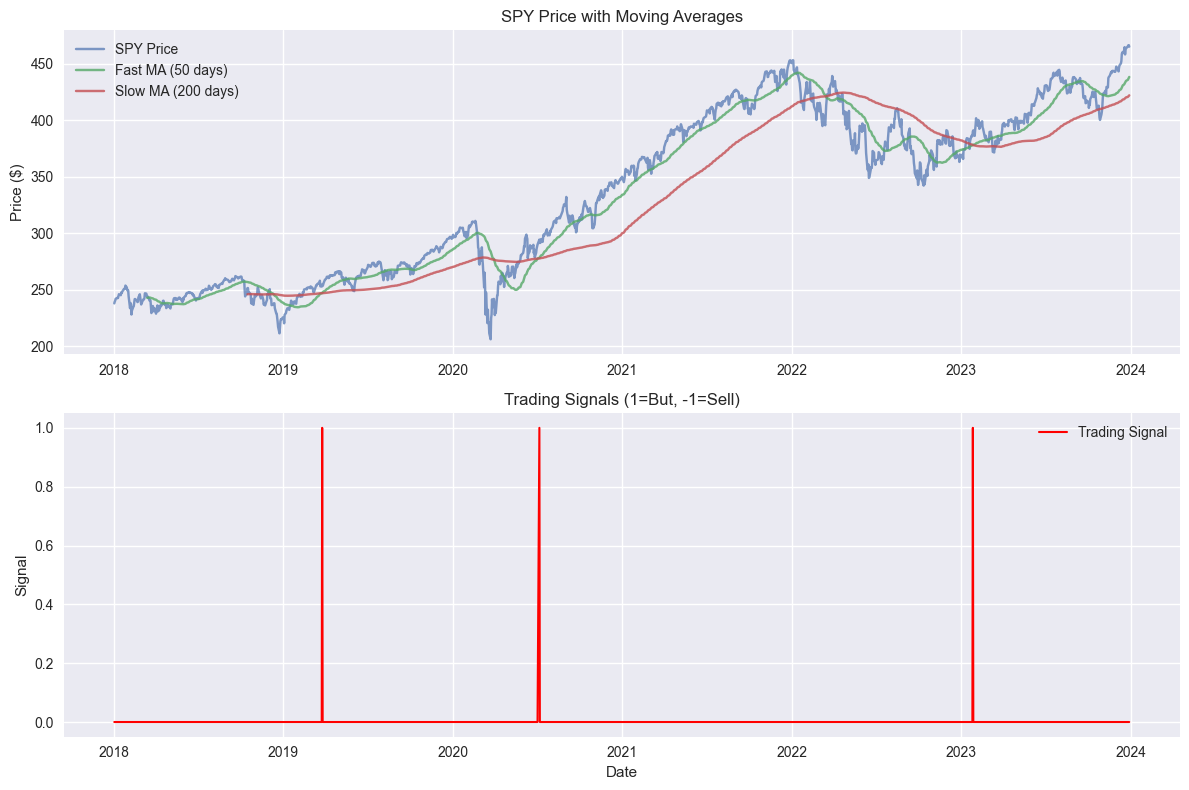

In [5]:
# VISUALIZE WHAT WE HAVE SO FAR
plt.figure(figsize=(12,8))

plt.subplot(2,1,1)
plt.plot(data['Close'], label='SPY Price', alpha=0.7)
plt.plot(data['Short_MA'],label=f'Fast MA ({short_window} days)', alpha=0.8)
plt.plot(data['Long_MA'],label=f'Slow MA ({long_window} days)', alpha=0.8)
plt.title('SPY Price with Moving Averages')
plt.legend()
plt.ylabel('Price ($)')

plt.subplot(2,1,2)
plt.plot(data['Signal'],label='Trading Signal', color='red', linewidth=1.5)
plt.title('Trading Signals (1=But, -1=Sell)')
plt.legend()
plt.ylabel('Signal')
plt.xlabel('Date')

plt.tight_layout()
plt.show()

In [6]:
# CALCULATE STRATEGY RUNS

# Calculate daily returns for the stock
data['Returns'] = data['Close'].pct_change()

# Forward-fill the signals (once we buy, we stay invested until we sell)
data['Position'] = data['Signal'].replace(to_replace=0, method='ffill')

# Calculate strategy returns (we're either invested or in cash)
data['Strategy_Returns'] = data['Position'].shift(1) * data['Returns']

# Returns = daily percentage change in price
# Strategy_Returns = our profit/loss each day based on our signals
# shift(1) means we use yesterday's signal to trade today (realistic!)

# Remove missing values
data = data.dropna()

print("📈First look at our returns:")
print(data[['Returns','Strategy_Returns','Signal']].head(10))

📈First look at our returns:
Price        Returns Strategy_Returns Signal
Ticker                                      
Date                                        
2018-10-16  0.021866              0.0      0
2018-10-17  0.000178              0.0      0
2018-10-18 -0.014441             -0.0      0
2018-10-19 -0.000543             -0.0      0
2018-10-22 -0.004489             -0.0      0
2018-10-23 -0.005091             -0.0      0
2018-10-24 -0.030299             -0.0      0
2018-10-25  0.017940              0.0      0
2018-10-26 -0.017587             -0.0      0
2018-10-29 -0.005541             -0.0      0


C:\Users\Aadya Nair\AppData\Local\Temp\ipykernel_9244\4089224250.py:7: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  data['Position'] = data['Signal'].replace(to_replace=0, method='ffill')


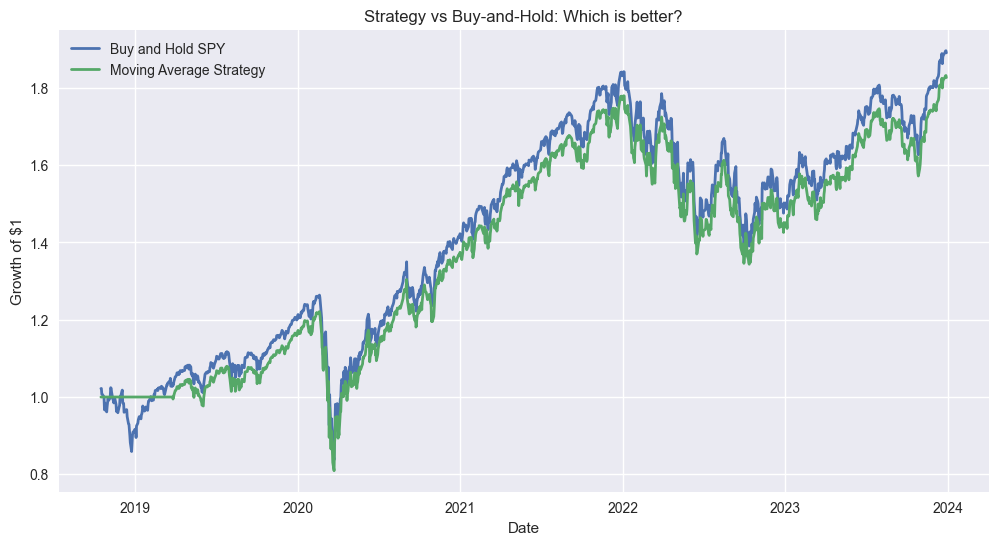

🎯 FINAL RESULT:
Buy-and-Hold Return: 89.06%
Strategy Return: 82.66%


In [7]:
# COMPARE TO BUY AND HOLD

# Calculate cumulative returns for both strategies
data['Cumulative_Market'] = (1 + data['Returns']).cumprod()
data['Cumulative_Strategy'] = (1 + data['Strategy_Returns']).cumprod()

# Plotting the comparisons
plt.figure(figsize = (12,6))
plt.plot(data['Cumulative_Market'], label='Buy and Hold SPY', linewidth=2)
plt.plot(data['Cumulative_Strategy'], label='Moving Average Strategy', linewidth=2)
plt.title('Strategy vs Buy-and-Hold: Which is better?')
plt.ylabel('Growth of $1')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.show()

final_market_return = (data['Cumulative_Market'].iloc[-1] - 1) * 100
final_strategy_return = (data['Cumulative_Strategy'].iloc[-1] - 1) * 100

print(f"🎯 FINAL RESULT:")
print(f"Buy-and-Hold Return: {final_market_return:.2f}%")
print(f"Strategy Return: {final_strategy_return:.2f}%")

✅ Clean signals created successfully!

📊 Signal Distribution:
Signal
0    1307
1       3
Name: count, dtype: int64

📊 Position Distribution:
Position
1    1201
0     109
Name: count, dtype: int64


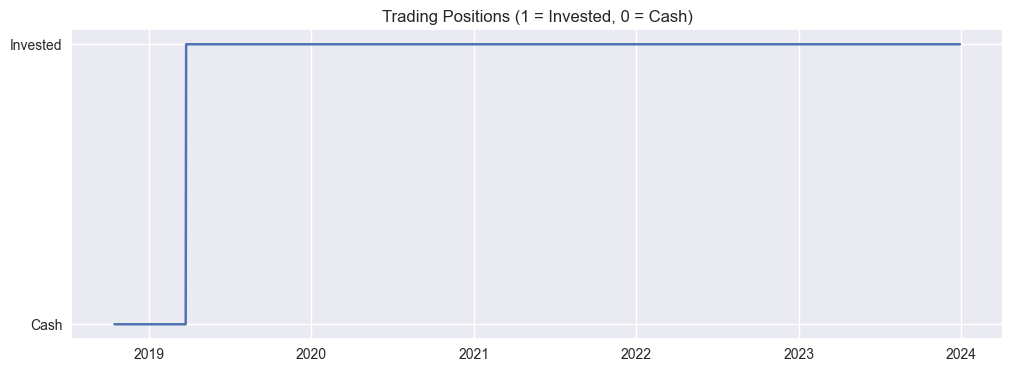

In [8]:
print("✅ Clean signals created successfully!")
print("\n📊 Signal Distribution:")
print(data['Signal'].value_counts())
print("\n📊 Position Distribution:")
print(data['Position'].value_counts())

# Plot to see our new positions
plt.figure(figsize=(12, 4))
plt.plot(data['Position'])
plt.title('Trading Positions (1 = Invested, 0 = Cash)')
plt.yticks([0, 1], ['Cash', 'Invested'])
plt.show()


🎯 UPDATED FINAL RESULTS:
Buy-and-Hold Return: 89.06%
Strategy Return: 82.66%


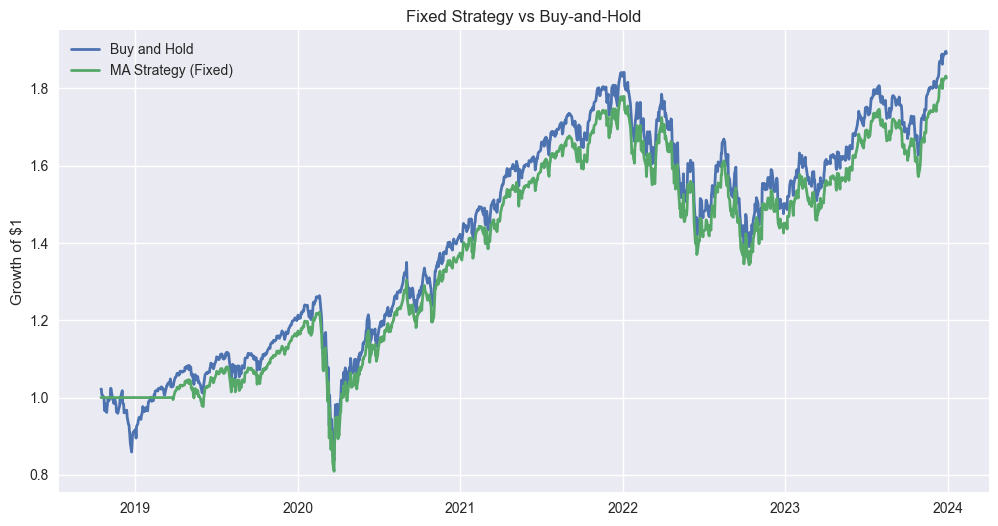

In [9]:
# Calculate final performance
final_market = (data['Cumulative_Market'].iloc[-1] - 1) * 100
final_strategy = (data['Cumulative_Strategy'].iloc[-1] - 1) * 100

print("\n🎯 UPDATED FINAL RESULTS:")
print(f"Buy-and-Hold Return: {final_market:.2f}%")
print(f"Strategy Return: {final_strategy:.2f}%")

# Plot comparison
plt.figure(figsize=(12, 6))
plt.plot(data['Cumulative_Market'], label='Buy and Hold', linewidth=2)
plt.plot(data['Cumulative_Strategy'], label='MA Strategy (Fixed)', linewidth=2)
plt.title('Fixed Strategy vs Buy-and-Hold')
plt.legend()
plt.ylabel('Growth of $1')
plt.show()